# 1. Librerías


In [53]:
# Datos
import pandas as pd
import numpy as np
import pickle
from datetime import datetime

#Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Métricas de evaluación
from sklearn.metrics import mean_squared_error,mean_absolute_error, r2_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Modelos a Entrenar
import xgboost as xgb

# inhabilita warnings
import warnings
warnings.filterwarnings("ignore")

# 2. Load Data

In [54]:
df = pd.read_csv('C:/Users/aalei/Desktop/GITHUB_DQ/clean_data.csv')
print('Rows: ', df.shape[0], '  Columns: ', df.shape[1])
df.head(2)

Rows:  14484   Columns:  8


,date,id,region,store,category,item,price,sales
0,2013-01-31,12_11365,16,12,9,11365,1511.512626,30.0
1,2013-02-28,12_11365,16,12,9,11365,1533.125000,27.0


In [55]:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

# 3. Feature Engineering

In [56]:
# Variables temporales
#df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
#df['year'] = df['date'].dt.year
#df['cumulative_month'] = (df['date'].dt.year - 2013) * 12 + df['date'].dt.month
df.head(2)

,date,id,region,store,category,item,price,sales,day
0,2013-01-31,12_11365,16,12,9,11365,1511.512626,30.0,31
1,2013-02-28,12_11365,16,12,9,11365,1533.125000,27.0,28


In [57]:
# Revenue y lag_1 de revenue
#df['revenue']= df['sales'] * df['price']
#df['id_revenue_mean_lag_1'] = df.groupby(["id"])["revenue"].transform(lambda series: series.shift(1))

# Sales lag_1 y diferencia de sales de 1 semana
#df['id_sales_sum_lag_1'] = df.groupby(["id"])["sales"].transform(lambda series: series.shift(1))
#df['id_sales_sum_lag_2'] = df.groupby(["id"])["sales"].transform(lambda series: series.shift(2))
#df['id_sales_sum_lag_3'] = df.groupby(["id"])["sales"].transform(lambda series: series.shift(3))
#df['dif_sales_1w'] = df['id_sales_sum_lag_1'] - df['sales']

# Sales lag_4 y diferencia de sales de 4 semanas
#df['id_sales_sum_lag_4'] = df.groupby(["id"])["sales"].transform(lambda series: series.shift(2))
#df['dif_sales_4w'] = df['id_sales_sum_lag_4'] - df['sales']

# Price lag_4 y diferencia de price de 4 semanas
#df['id_price_lag_4'] = df.groupby(["id"])["price"].transform(lambda series: series.shift(2))
#df['dif_price_4w'] = df['id_price_lag_4'] - df['price']

#df.head(2)

In [58]:
df1 = df[df['date'] < '2015-10-01'] # Quitar el mes de octubre que tiene algunos datos, pero es el mes que se busca predecir

In [59]:
# Función para crear lags de variables agrupadas
def build_ts_vars(df, gb_list, target_column, agg_func, agg_func_name,resample_value):
    assert "date" in df.columns.tolist(), "Date must be in df columns"
    new_name = "_".join(gb_list + [target_column] + [agg_func_name])

    gb_df_ = (
        df
        .set_index("date")
        .groupby(gb_list)
        .resample(resample_value)[target_column]
        .apply(agg_func)
        .to_frame()
        .reset_index()
        .rename(
            columns = {
                target_column : new_name
            }
        )
    )
    gb_df_[f"{new_name}_lag_1"] = gb_df_.groupby(gb_list)[new_name].transform(
        lambda series: series.shift(1)
    )
    gb_df_[f"{new_name}_lag_2"] = gb_df_.groupby(gb_list)[new_name].transform(
        lambda series: series.shift(2)
    )
    gb_df_[f"{new_name}_lag_3"] = gb_df_.groupby(gb_list)[new_name].transform(
        lambda series: series.shift(3)
    )
    gb_df_[f"{new_name}_lag_4"] = gb_df_.groupby(gb_list)[new_name].transform(
        lambda series: series.shift(4)
    )
    #gb_df_[f"{new_name}_lag_12"] = gb_df_.groupby(gb_list)[new_name].transform(
    #    lambda series: series.shift(12)
    #)
    print(f"Plus 3 lags features for: {new_name}")
    gb_df_.drop(new_name, inplace = True, axis = 1)

    return gb_df_

In [60]:
'''vars_ts_item_id = build_ts_vars(
 full_df = full_df,
 gb_list = ["DATE", "SHOP_ID", "ITEM_ID"],
 target_column = "MONTHLY_SALES",
 agg_func = np.sum,
 agg_func_name = "SUM"
)

2. Otra cosa que he visto muy a menudo: personas que generan variable autoexplicativas (agrupaban las ventas por item_category_id por ejemplo y no dropeaban el mes de entrenamiento). OJO con este tipo de cosas.
3. Otro fallo bastante común es olvidarse que estamos trabajando con 299 TS. Por este motivo, si quiero generar una media móvil. Tengo que hacer algo parecido a esto:
df["SALES_MA_3"] = df.groupby(["unique_id"])["SALES"].transform(lambda series: series.shift(1).rolling(3).mean())'''

'vars_ts_item_id = build_ts_vars(\n full_df = full_df,\n gb_list = ["DATE", "SHOP_ID", "ITEM_ID"],\n target_column = "MONTHLY_SALES",\n agg_func = np.sum,\n agg_func_name = "SUM"\n)\n\n2. Otra cosa que he visto muy a menudo: personas que generan variable autoexplicativas (agrupaban las ventas por item_category_id por ejemplo y no dropeaban el mes de entrenamiento). OJO con este tipo de cosas.\n3. Otro fallo bastante común es olvidarse que estamos trabajando con 299 TS. Por este motivo, si quiero generar una media móvil. Tengo que hacer algo parecido a esto:\ndf["SALES_MA_3"] = df.groupby(["unique_id"])["SALES"].transform(lambda series: series.shift(1).rolling(3).mean())'

In [61]:
df.head(2)

,date,id,region,store,category,item,price,sales,day
0,2013-01-31,12_11365,16,12,9,11365,1511.512626,30.0,31
1,2013-02-28,12_11365,16,12,9,11365,1533.125000,27.0,28


In [62]:
# TARGET: SALES
print(f'Dimensión inicial df: {df.shape}')

# Add the previous month's average item_cnt
vars_ts_ = build_ts_vars(
    df = df1,
    gb_list = ["store","item"],
    target_column = "sales",
    agg_func = np.sum,
    agg_func_name = "sum",
    resample_value='M')
df = pd.merge(df, vars_ts_, on = ["date"] + ["store","item"], how = "left")

'''# Add the previous month's average item_cnt
vars_ts_ = build_ts_vars(
    df = df1,
    gb_list = ["store","category","item"],
    target_column = "sales",
    agg_func = np.sum,
    agg_func_name = "sum",
    resample_value='M')
df = pd.merge(df, vars_ts_, on = ["date"] + ["store","category","item"], how = "left")

# Add lag values of item_cnt_month for month / item_id.
vars_ts_ = build_ts_vars(
    df = df1,
    gb_list = ["cumulative_month","item"],
    target_column = "sales",
    agg_func = np.mean,
    agg_func_name = "mean",
    resample_value='M')
df = pd.merge(df, vars_ts_, on = ["date"] + ["cumulative_month","item"], how = "left")

# Add lag values for item_cnt_month for every month / shop combination
vars_ts_ = build_ts_vars(
    df = df1,
    gb_list = ["cumulative_month","store"],
    target_column = "sales",
    agg_func = np.mean,
    agg_func_name = "mean",
    resample_value='M')
df = pd.merge(df, vars_ts_, on = ["date"] + ["cumulative_month","store"], how = "left")

# Add lag values for item_cnt_month for month/shop/item
vars_ts_ = build_ts_vars(
    df = df1,
    gb_list = ["cumulative_month","store","item"],
    target_column = "sales",
    agg_func = np.mean,
    resample_value='M',
    agg_func_name = "mean")
df = pd.merge(df, vars_ts_, on = ["date"] + ["cumulative_month","store","item"], how = "left")

# Add lag values for item_cnt_month for month/shop/item subtype
vars_ts_ = build_ts_vars(
    df = df1,
    gb_list = ["cumulative_month","store","category","item"],
    target_column = "sales",
    agg_func = np.mean,
    agg_func_name =  "mean",
    resample_value='M')
df = pd.merge(df, vars_ts_, on = ["date"] + ["cumulative_month","store","category","item"], how = "left")

# Add lag values for item_cnt_month for month/city
vars_ts_ = build_ts_vars(
    df = df1,
    gb_list = ["cumulative_month","region"],
    target_column = "sales",
    agg_func = np.mean,
    agg_func_name =  "mean",
    resample_value='M')
df = pd.merge(df, vars_ts_, on = ["date"] + ["cumulative_month","region"], how = "left")

# Add lag values for item_cnt_month for month/city/item
vars_ts_ = build_ts_vars(
    df = df1,
    gb_list = ["cumulative_month","region","item"],
    target_column = "sales",
    agg_func = np.mean,
    agg_func_name = "mean",
    resample_value='M')
df = pd.merge(df, vars_ts_, on = ["date"] + ["cumulative_month","region","item"], how = "left")

# Suma de ventas agrupadas por category, department e item
vars_ts_ = build_ts_vars(
    df = df,
    gb_list = ["category","region","item"],
    target_column = "sales",
    agg_func = np.sum,
    agg_func_name = "sum",
    resample_value='M')
df = pd.merge(df, vars_ts_, on = ["date"] + ["category","region","item"], how = "left")

# Promedio de ventas agrupado por category, event, item y region
vars_ts_ = build_ts_vars(
    df = df,
    gb_list = ["category","item","region"],
    target_column = "sales",
    agg_func = np.mean,
    agg_func_name =  "mean",
    resample_value='M')
df = pd.merge(df, vars_ts_, on = ["date"] + ["category","item","region"], how = "left")'''

print(f'Dimensión final df: {df.shape}')
df.head()

Dimensión inicial df: (14484, 9)
Plus 3 lags features for: store_item_sales_sum
Dimensión final df: (14484, 13)


,date,id,region,store,category,item,price,sales,day,store_item_sales_sum_lag_1,store_item_sales_sum_lag_2,store_item_sales_sum_lag_3,store_item_sales_sum_lag_4
0,2013-01-31,12_11365,16,12,9,11365,1511.512626,30.0,31,NaN,NaN,NaN,NaN
1,2013-02-28,12_11365,16,12,9,11365,1533.125000,27.0,28,30.0,NaN,NaN,NaN
2,2013-03-31,12_11365,16,12,9,11365,3252.470238,30.0,31,27.0,30.0,NaN,NaN
3,2013-04-30,12_11365,16,12,9,11365,1590.515152,27.0,30,30.0,27.0,30.0,NaN
4,2013-05-31,12_11365,16,12,9,11365,1447.531250,30.0,31,27.0,30.0,27.0,30.0


In [63]:
'''# TARGET: PRICE
print(f'Dimensión inicial df: {df.shape}')
# Promedio de revenue agrupado por store e item
vars_ts_ = build_ts_vars(
    df = df,
    gb_list = ["store","item"],
    target_column = "price",
    agg_func = np.mean,
    agg_func_name =  "mean",
    resample_value='M')
df = pd.merge(df, vars_ts_, on = ["date"] + ["store","item"], how = "left")

# Promedio de ventas agrupadas por item y evento
vars_ts_ = build_ts_vars(
    df = df,
    gb_list = ["id","item"],
    target_column = "price",
    agg_func = np.mean,
    agg_func_name = "mean",
    resample_value='M')
df = pd.merge(df, vars_ts_, on = ["date"] + ["id","item"], how = "left")
print(f'Dimensión final df: {df.shape}')
df.head()'''

'# TARGET: PRICE\nprint(f\'Dimensión inicial df: {df.shape}\')\n# Promedio de revenue agrupado por store e item\nvars_ts_ = build_ts_vars(\n    df = df,\n    gb_list = ["store","item"],\n    target_column = "price",\n    agg_func = np.mean,\n    agg_func_name =  "mean",\n    resample_value=\'M\')\ndf = pd.merge(df, vars_ts_, on = ["date"] + ["store","item"], how = "left")\n\n# Promedio de ventas agrupadas por item y evento\nvars_ts_ = build_ts_vars(\n    df = df,\n    gb_list = ["id","item"],\n    target_column = "price",\n    agg_func = np.mean,\n    agg_func_name = "mean",\n    resample_value=\'M\')\ndf = pd.merge(df, vars_ts_, on = ["date"] + ["id","item"], how = "left")\nprint(f\'Dimensión final df: {df.shape}\')\ndf.head()'

In [64]:
# TARGET: REVENUE

# Borrar features que no serán parte del modelo

In [65]:
COLUMNS_TO_DROP = [] 
df.drop(COLUMNS_TO_DROP, inplace = True, axis = 1)

In [66]:
print(df.columns)

Index(['date', 'id', 'region', 'store', 'category', 'item', 'price', 'sales',
       'day', 'store_item_sales_sum_lag_1', 'store_item_sales_sum_lag_2',
       'store_item_sales_sum_lag_3', 'store_item_sales_sum_lag_4'],
      dtype='object')


In [67]:
df.set_index("id", inplace = True)
df.sample(3)

,date,region,store,category,item,price,sales,day,store_item_sales_sum_lag_1,store_item_sales_sum_lag_2,store_item_sales_sum_lag_3,store_item_sales_sum_lag_4
id,,,,,,,,,,,,
24_20949,2014-07-31,7,24,71,20949,5.0,30.0,31,30.0,30.0,30.0,30.0
26_5822,2015-08-31,7,26,35,5822,1149.0,12.0,31,6.0,11.0,29.0,14.0
16_7894,2013-01-31,4,16,6,7894,1490.0,5.0,31,NaN,NaN,NaN,NaN


# Train Test Split

In [68]:
train_index = sorted(list(df["date"].unique()))[:-2]

valida_index = [sorted(list(df["date"].unique()))[-2]]

test_index = [sorted(list(df["date"].unique()))[-1]]

print(f"Our train index is {train_index[:2]} - ... - {train_index[-2:]}\n")
print(f"Our validation index is {valida_index}\n")
print(f"Our test/prediction index is {test_index}\n")

Our train index is [Timestamp('2013-01-31 00:00:00'), Timestamp('2013-02-28 00:00:00')] - ... - [Timestamp('2015-07-31 00:00:00'), Timestamp('2015-08-31 00:00:00')]

Our validation index is [Timestamp('2015-09-30 00:00:00')]

Our test/prediction index is [Timestamp('2015-10-31 00:00:00')]



In [69]:
X_train = df[df["date"].isin(train_index)].drop(['sales', "date"], axis=1)
Y_train = df[df["date"].isin(train_index)]['sales']

X_valida = df[df["date"].isin(valida_index)].drop(['sales', "date"], axis=1)
Y_valida = df[df["date"].isin(valida_index)]['sales']

X_test = df[df["date"].isin(test_index)].drop(['sales', "date"], axis = 1)
Y_test = df[df["date"].isin(test_index)]['sales']

In [70]:
print(f'Train shape: {X_train.shape}, Valida shape: {X_valida.shape}, Test shape: {X_test.shape}')

Train shape: (13632, 10), Valida shape: (426, 10), Test shape: (426, 10)


In [71]:
X_train.head(2)

,region,store,category,item,price,day,store_item_sales_sum_lag_1,store_item_sales_sum_lag_2,store_item_sales_sum_lag_3,store_item_sales_sum_lag_4
id,,,,,,,,,,
12_11365,16,12,9,11365,1511.512626,31,NaN,NaN,NaN,NaN
12_11365,16,12,9,11365,1533.125000,28,30.0,NaN,NaN,NaN


In [72]:
X_test.head(2)

,region,store,category,item,price,day,store_item_sales_sum_lag_1,store_item_sales_sum_lag_2,store_item_sales_sum_lag_3,store_item_sales_sum_lag_4
id,,,,,,,,,,
12_11365,16,12,9,11365,0.0,31,NaN,NaN,NaN,NaN
12_11369,16,12,9,11369,0.0,31,NaN,NaN,NaN,NaN


In [73]:
Y_test.sum()  # debe ser 0

0.0

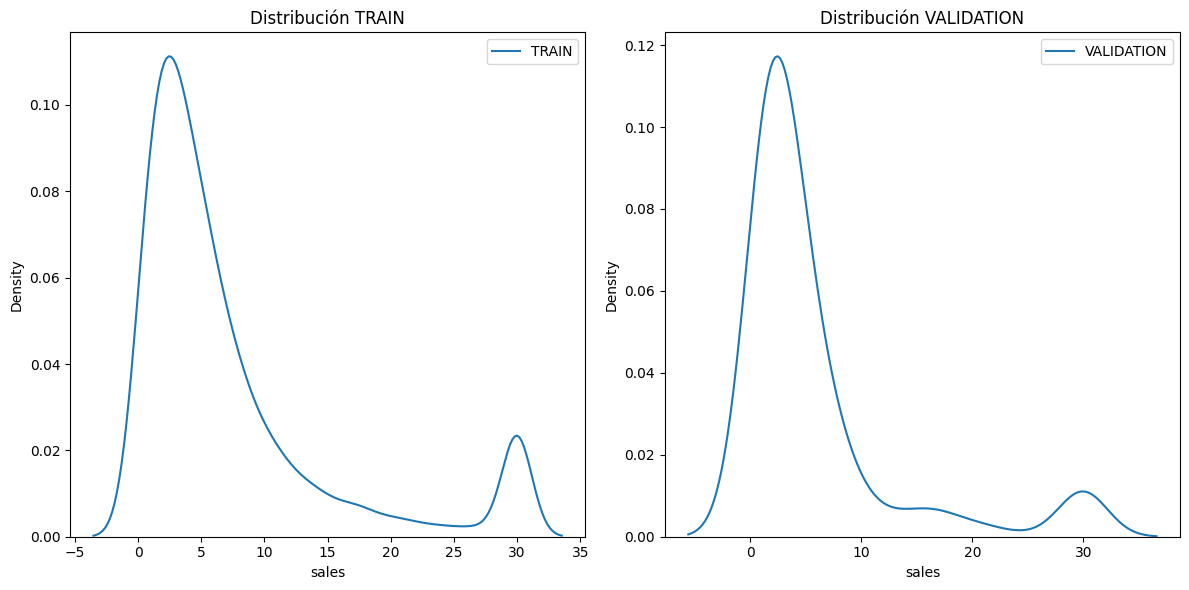

In [74]:
# Distribucion de target en train y validación
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

sns.kdeplot(Y_train, ax=axes[0], label='TRAIN')
axes[0].set_title('Distribución TRAIN')
axes[0].legend()

sns.kdeplot(Y_valida, ax=axes[1], label='VALIDATION')
axes[1].set_title('Distribución VALIDATION')
axes[1].legend()

plt.tight_layout()
plt.show()


# Model Train

In [75]:
model = xgb.XGBRegressor(seed=175)

model.fit(
     X_train,
     Y_train,
     eval_metric = "rmse", 
     eval_set = [(X_train, Y_train), (X_valida, Y_valida)],  
     verbose = True,
     early_stopping_rounds = 15
     )

[0]	validation_0-rmse:6.29850	validation_1-rmse:5.83695
[1]	validation_0-rmse:5.30172	validation_1-rmse:4.71847
[2]	validation_0-rmse:4.70043	validation_1-rmse:4.01103
[3]	validation_0-rmse:4.35092	validation_1-rmse:3.56270
[4]	validation_0-rmse:4.12767	validation_1-rmse:3.29500
[5]	validation_0-rmse:4.00532	validation_1-rmse:3.14702
[6]	validation_0-rmse:3.91812	validation_1-rmse:3.07196
[7]	validation_0-rmse:3.85777	validation_1-rmse:2.99939
[8]	validation_0-rmse:3.80828	validation_1-rmse:2.98930
[9]	validation_0-rmse:3.74144	validation_1-rmse:2.99087
[10]	validation_0-rmse:3.67367	validation_1-rmse:2.97079
[11]	validation_0-rmse:3.62872	validation_1-rmse:2.98315
[12]	validation_0-rmse:3.58575	validation_1-rmse:3.00155
[13]	validation_0-rmse:3.55316	validation_1-rmse:3.01765
[14]	validation_0-rmse:3.51635	validation_1-rmse:2.99949
[15]	validation_0-rmse:3.49806	validation_1-rmse:2.98680
[16]	validation_0-rmse:3.47752	validation_1-rmse:2.97770
[17]	validation_0-rmse:3.45667	validation

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

# Features Importance

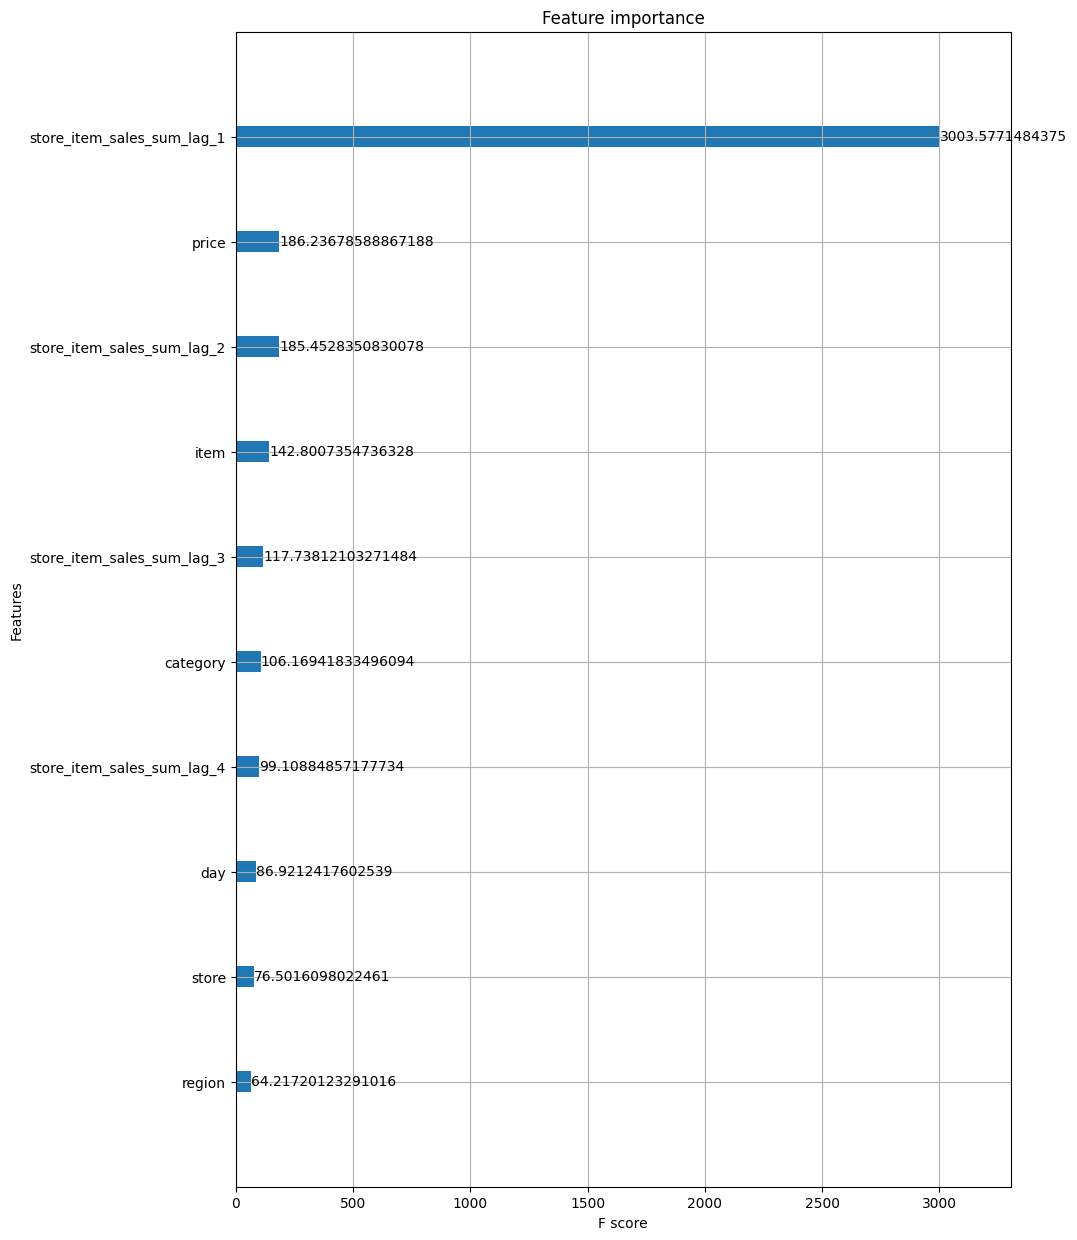

In [76]:
fig, ax = plt.subplots(figsize = (10, 15))
xgb.plot_importance(model, importance_type = "gain", ax = ax);

# Model Predict

In [77]:

Y_train_predict = model.predict(X_train).clip(0,30)
Y_valida_predict = model.predict(X_valida).clip(0,30)

rmse_train = np.sqrt(
    mean_squared_error(
        y_true = Y_train,
        y_pred = Y_train_predict
    )
)

rmse_valida = np.sqrt(
    mean_squared_error(
        y_true = Y_valida,
        y_pred = Y_valida_predict
    )
)

rmse_train= str(round(rmse_train, 3)).replace(".", "_")
rmse_valida = str(round(rmse_valida, 3)).replace(".", "_")

print(f"Train RMSE: {rmse_train}")
print(f"Validation RMSE: {rmse_valida}")

Train RMSE: 3_182
Validation RMSE: 2_937


# Model Evaluations

### Evaluación del Error

RMSE: 2.9367
MAE: 1.9463
R2-Score: 84.16%


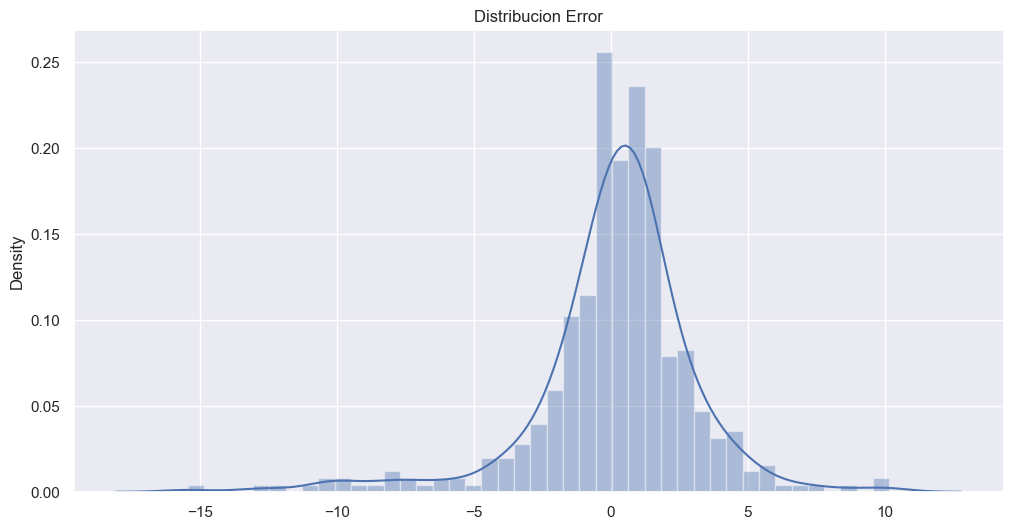

In [78]:
error = Y_valida_predict - Y_valida.values

mae = np.mean(np.abs(error))
mse = np.mean(error**2)
rmse = np.sqrt(np.mean(error**2))

print('RMSE:', round(rmse,4))
print('MAE:', round(mae,4))
print('R2-Score: {:.2%}'.format(r2_score(Y_valida, Y_valida_predict)))

sns.set(rc={'figure.figsize':(12,6)})
sns.distplot(error).set_title('Distribucion Error')
plt.show()

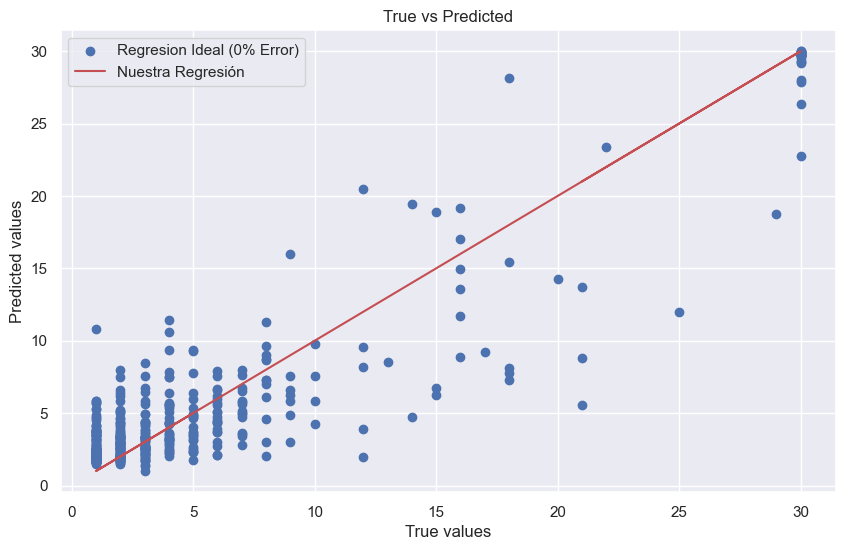

In [79]:
#Compara Prediccion vs dato real
plt.figure(figsize=[10,6])
plt.scatter(Y_valida, Y_valida_predict)
plt.plot(Y_valida, Y_valida,'r')
plt.title('True vs Predicted')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.legend(['Regresion Ideal (0% Error)','Nuestra Regresión'])
plt.show()

### Intervalo de confianza del Error

In [80]:
confidence=95
z = (100-confidence)/2
print("Intervalo del error (confianza",confidence,"%):",round(np.percentile(error, 100-z),1),"/",round(np.percentile(error, z),1))

Intervalo del error (confianza 95 %): 5.0 / -8.1


### Predición en datos de validacion

In [81]:
# Agregar la predicción como una nueva columna al DataFrame X_valida
X_valida.reset_index(inplace = True)
X_valida.head(2)
X_valida['sales_predict'] = Y_valida_predict

In [82]:
X_valida.head()

,id,region,store,category,item,price,day,store_item_sales_sum_lag_1,store_item_sales_sum_lag_2,store_item_sales_sum_lag_3,store_item_sales_sum_lag_4,sales_predict
0,12_11365,16,12,9,11365,995.680556,30,13.0,6.0,11.0,30.0,13.682614
1,12_11369,16,12,9,11369,1321.367605,30,21.0,30.0,30.0,30.0,22.764364
2,12_11370,16,12,9,11370,681.715341,30,30.0,30.0,30.0,30.0,29.976801
3,12_11373,16,12,9,11373,437.929115,30,30.0,30.0,30.0,30.0,30.000000
4,12_12231,16,12,49,12231,350.000000,30,2.0,1.0,4.0,1.0,2.549664


# Test Prediction

In [83]:
# Eliminar la columna 'sales' si está presente
if "sales" in X_test.columns:
    X_test.drop("sales", axis=1, inplace=True)

# Realizar la predicción
Y_test_predict = model.predict(X_test).clip(0,30)

# Agregar la predicción como una nueva columna al DataFrame X_test
X_test.reset_index(inplace = True)
X_test['sales'] = Y_test_predict
X_test.head(2)

,id,region,store,category,item,price,day,store_item_sales_sum_lag_1,store_item_sales_sum_lag_2,store_item_sales_sum_lag_3,store_item_sales_sum_lag_4,sales
0,12_11365,16,12,9,11365,0.0,31,NaN,NaN,NaN,NaN,2.357872
1,12_11369,16,12,9,11369,0.0,31,NaN,NaN,NaN,NaN,2.357872


In [84]:
X_test.shape

(426, 12)